# DeepSurv深度学习生存分析模型

本notebook实现了DeepSurv深度神经网络模型，用于癌症患者生存分析预测。DeepSurv是基于Cox比例风险模型的深度学习扩展，能够捕获非线性特征交互。

## 目标
- 构建和训练DeepSurv深度学习模型
- 评估模型性能并与传统方法对比
- 分析模型的预测能力和特征重要性

## 1. 导入库和加载数据

In [3]:
# 基础库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# 设置matplotlib中文字体
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = ['Noto Serif CJK JP']
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100

# 深度学习库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# 生存分析库
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
from sksurv.metrics import concordance_index_censored

# 科学计算库
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import pickle
from pathlib import Path
import os

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 检查CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

print("库导入完成！")

使用设备: cuda
库导入完成！


In [4]:
# 加载预处理后的数据
data_dir = Path('../data/processed')

print("正在加载数据...")

try:
    # 尝试加载真实数据
    train_data = pd.read_csv(data_dir / 'train_data.csv')
    test_data = pd.read_csv(data_dir / 'test_data.csv')
    
    # 加载预处理器
    with open(data_dir / 'preprocessors.pkl', 'rb') as f:
        preprocessors = pickle.load(f)
    
    feature_columns = preprocessors['feature_columns']
    
    print(f"✅ 真实数据加载成功!")
    print(f"   训练数据形状: {train_data.shape}")
    print(f"   测试数据形状: {test_data.shape}")
    print(f"   特征数量: {len(feature_columns)}")
    
    # 检查数据质量
    print(f"\n📊 数据质量检查:")
    print(f"   训练集缺失值: {train_data.isnull().sum().sum()}")
    print(f"   测试集缺失值: {test_data.isnull().sum().sum()}")
    
except FileNotFoundError as e:
    print(f"❌ 真实数据文件不存在: {e}")
    print("正在生成模拟数据用于演示...")
    
    # 生成模拟数据
    np.random.seed(42)
    
    n_train = 2000
    n_test = 500
    n_features = 20
    
    # 创建特征名称
    feature_columns = [f'feature_{i+1}' for i in range(n_features)]
    
    # 生成训练数据
    X_train_sim = np.random.randn(n_train, n_features)
    # 添加一些特征间的相关性
    X_train_sim[:, 1] += 0.5 * X_train_sim[:, 0] + np.random.randn(n_train) * 0.3
    X_train_sim[:, 2] -= 0.3 * X_train_sim[:, 0] + np.random.randn(n_train) * 0.4
    
    # 生成生存时间（基于特征的线性组合 + 噪声）
    risk_coef = np.random.randn(n_features) * 0.3
    linear_predictor = X_train_sim @ risk_coef
    
    # 使用指数分布生成生存时间
    baseline_hazard = 0.1
    y_train_duration_sim = np.random.exponential(1 / (baseline_hazard * np.exp(linear_predictor)))
    
    # 生成事件指示器（30%的事件率）
    y_train_event_sim = np.random.binomial(1, 0.3, n_train)
    
    # 对于删失样本，调整生存时间
    censoring_times = np.random.exponential(20, n_train)  # 删失时间
    observed_times = np.minimum(y_train_duration_sim, censoring_times)
    events = (y_train_duration_sim <= censoring_times).astype(int)
    
    # 创建训练DataFrame
    train_data = pd.DataFrame(X_train_sim, columns=feature_columns)
    train_data['Duration'] = observed_times
    train_data['Event'] = events
    train_data['PatientID'] = range(n_train)
    
    # 类似地生成测试数据
    X_test_sim = np.random.randn(n_test, n_features)
    X_test_sim[:, 1] += 0.5 * X_test_sim[:, 0] + np.random.randn(n_test) * 0.3
    X_test_sim[:, 2] -= 0.3 * X_test_sim[:, 0] + np.random.randn(n_test) * 0.4
    
    linear_predictor_test = X_test_sim @ risk_coef
    y_test_duration_sim = np.random.exponential(1 / (baseline_hazard * np.exp(linear_predictor_test)))
    
    censoring_times_test = np.random.exponential(20, n_test)
    observed_times_test = np.minimum(y_test_duration_sim, censoring_times_test)
    events_test = (y_test_duration_sim <= censoring_times_test).astype(int)
    
    test_data = pd.DataFrame(X_test_sim, columns=feature_columns)
    test_data['Duration'] = observed_times_test
    test_data['Event'] = events_test
    test_data['PatientID'] = range(n_test)
    
    print(f"✅ 模拟数据生成成功!")
    print(f"   训练数据形状: {train_data.shape}")
    print(f"   测试数据形状: {test_data.shape}")
    print(f"   特征数量: {len(feature_columns)}")
    print(f"   注意: 这是模拟数据，仅用于演示目的")

# 准备训练数据
X_train = train_data[feature_columns].values
y_train_duration = train_data['Duration'].values
y_train_event = train_data['Event'].values

X_test = test_data[feature_columns].values
y_test_duration = test_data['Duration'].values
y_test_event = test_data['Event'].values

# 数据标准化（DeepSurv需要标准化的输入）
print(f"\n🔧 数据预处理:")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"   特征标准化: ✅")
train_means = X_train.mean(axis=0)[:3]
train_stds = X_train.std(axis=0)[:3]
print(f"   训练集均值: [{train_means[0]:.3f}, {train_means[1]:.3f}, {train_means[2]:.3f}]... (前3个特征)")
print(f"   训练集标准差: [{train_stds[0]:.3f}, {train_stds[1]:.3f}, {train_stds[2]:.3f}]... (前3个特征)")

# 数据质量检查
print(f"\n📊 数据统计:")
print(f"   训练集事件率: {y_train_event.mean():.2%}")
print(f"   测试集事件率: {y_test_event.mean():.2%}")
print(f"   平均生存时间 (训练): {y_train_duration.mean():.1f}月")
print(f"   平均生存时间 (测试): {y_test_duration.mean():.1f}月")
print(f"   生存时间范围: [{y_train_duration.min():.1f}, {y_train_duration.max():.1f}]月")

# 转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train)
y_train_duration_tensor = torch.FloatTensor(y_train_duration)
y_train_event_tensor = torch.FloatTensor(y_train_event)

X_test_tensor = torch.FloatTensor(X_test)
y_test_duration_tensor = torch.FloatTensor(y_test_duration)
y_test_event_tensor = torch.FloatTensor(y_test_event)

print(f"✅ 数据加载和预处理完成！")
print(f"   张量设备: {X_train_tensor.device}")
print(f"   数据类型: {X_train_tensor.dtype}")

正在加载数据...
✅ 真实数据加载成功!
   训练数据形状: (16000, 48)
   测试数据形状: (4000, 48)
   特征数量: 46

📊 数据质量检查:
   训练集缺失值: 0
   测试集缺失值: 0

🔧 数据预处理:
   特征标准化: ✅
   训练集均值: [0.000, 0.000, 0.000]... (前3个特征)
   训练集标准差: [1.000, 1.000, 1.000]... (前3个特征)

📊 数据统计:
   训练集事件率: 36.20%
   测试集事件率: 36.20%
   平均生存时间 (训练): 30.6月
   平均生存时间 (测试): 30.1月
   生存时间范围: [1.0, 60.0]月
✅ 数据加载和预处理完成！
   张量设备: cpu
   数据类型: torch.float32


## 2. DeepSurv模型定义

In [5]:
class DeepSurv(nn.Module):
    """
    原版DeepSurv模型实现
    基于Katzman et al. (2018) 的原始论文
    
    完全按照原始论文实现，不包含任何额外的扩展功能：
    - 只使用ReLU激活函数
    - 不使用BatchNorm
    - 不使用残差连接
    - 简单的全连接层 + Dropout + ReLU
    """
    
    def __init__(self, input_dim, hidden_dims=[100, 50, 25], dropout_rate=0.5):
        super(DeepSurv, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.dropout_rate = dropout_rate
        
        # 构建简单的全连接网络
        layers = []
        prev_dim = input_dim
        
        # 隐藏层
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # 输出层（单个神经元，输出风险得分）
        layers.append(nn.Linear(prev_dim, 1))
        
        # 创建序列模型
        self.network = nn.Sequential(*layers)
        
        # 简单的权重初始化
        self._initialize_weights()
        
        print(f"原版DeepSurv模型创建完成:")
        print(f"  - 输入维度: {input_dim}")
        print(f"  - 隐藏层: {hidden_dims}")
        print(f"  - 激活函数: ReLU")
        print(f"  - Dropout率: {dropout_rate}")
        print(f"  - 网络结构: 全连接层 + ReLU + Dropout")
    
    def _initialize_weights(self):
        """
        简单的权重初始化
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # 使用标准的Xavier初始化
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """
        简单的前向传播
        """
        return self.network(x)
    
    def predict_risk(self, x, batch_size=1024):
        """
        批量预测风险得分
        """
        self.eval()
        risks = []
        
        with torch.no_grad():
            if isinstance(x, np.ndarray):
                x = torch.FloatTensor(x)
            
            # 批量处理
            for i in range(0, len(x), batch_size):
                batch = x[i:i+batch_size].to(next(self.parameters()).device)
                batch_risks = self.forward(batch)
                risks.append(batch_risks.cpu().numpy())
        
        return np.concatenate(risks, axis=0).flatten()
    
    def get_model_info(self):
        """返回模型信息"""
        total_params = sum(p.numel() for p in self.parameters())
        
        return {
            'total_parameters': total_params,
            'trainable_parameters': total_params,
            'model_size_mb': total_params * 4 / (1024 * 1024),
            'architecture': self.hidden_dims,
            'input_dim': self.input_dim
        }


# 创建原版DeepSurv模型实例
print("创建原版DeepSurv模型...")
input_dim = X_train.shape[1]

# 原版配置（严格按照原论文）
model = DeepSurv(
    input_dim=input_dim,
    hidden_dims=[100, 50, 25],  # 原论文推荐的架构
    dropout_rate=0.5            # 原论文使用的dropout率
)

model = model.to(device)

# 显示模型信息
model_info = model.get_model_info()
print(f"\n模型统计信息:")
for key, value in model_info.items():
    print(f"  {key}: {value}")

print(f"\n模型架构:")
print(model)

创建原版DeepSurv模型...
原版DeepSurv模型创建完成:
  - 输入维度: 46
  - 隐藏层: [100, 50, 25]
  - 激活函数: ReLU
  - Dropout率: 0.5
  - 网络结构: 全连接层 + ReLU + Dropout

模型统计信息:
  total_parameters: 11051
  trainable_parameters: 11051
  model_size_mb: 0.042156219482421875
  architecture: [100, 50, 25]
  input_dim: 46

模型架构:
DeepSurv(
  (network): Sequential(
    (0): Linear(in_features=46, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=50, out_features=25, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=25, out_features=1, bias=True)
  )
)

模型统计信息:
  total_parameters: 11051
  trainable_parameters: 11051
  model_size_mb: 0.042156219482421875
  architecture: [100, 50, 25]
  input_dim: 46

模型架构:
DeepSurv(
  (network): Sequential(
    (0): Linear(in_features=46, out_features=100, bias=True)
    (1):

## 3. Cox部分似然损失函数

In [4]:
def negative_log_partial_likelihood(risk_scores, durations, events):
    """
    标准的Cox模型负对数部分似然损失函数
    基于原始DeepSurv论文实现，优化了数值稳定性和计算效率
    
    Args:
        risk_scores: 模型预测的风险得分 [batch_size, 1] 或 [batch_size]
        durations: 生存时间 [batch_size]
        events: 事件指示器 [batch_size] (1=事件发生, 0=删失)
    
    Returns:
        negative log partial likelihood (标量)
    """
    # 确保risk_scores是一维的
    if risk_scores.dim() == 2:
        risk_scores = risk_scores.view(-1)
    
    # 只考虑发生事件的样本
    event_mask = events.bool()
    n_events = event_mask.sum()
    
    if n_events == 0:
        return torch.tensor(0.0, requires_grad=True, device=risk_scores.device)
    
    # 获取事件时间和对应的风险得分
    event_times = durations[event_mask]
    event_risks = risk_scores[event_mask]
    
    # 按时间排序（标准Cox模型要求）
    sorted_indices = torch.argsort(event_times)
    event_times_sorted = event_times[sorted_indices]
    event_risks_sorted = event_risks[sorted_indices]
    
    # 计算每个事件时间点的风险集
    log_likelihood = 0.0
    
    for i in range(len(event_times_sorted)):
        current_time = event_times_sorted[i]
        current_risk = event_risks_sorted[i]
        
        # 风险集：所有在当前时间点仍在观察中的样本
        # 包括在此时间发生事件的样本和生存时间大于此时间的样本
        at_risk_mask = durations >= current_time
        
        if at_risk_mask.sum() > 0:
            at_risk_risks = risk_scores[at_risk_mask]
            
            # 使用logsumexp确保数值稳定性
            log_sum_exp_risks = torch.logsumexp(at_risk_risks, dim=0)
            log_likelihood += current_risk - log_sum_exp_risks
    
    # 返回负对数似然的平均值
    return -log_likelihood / n_events


def efron_approximation_loss(risk_scores, durations, events):
    """
    Efron近似方法处理并列事件时间的Cox损失
    当数据中存在大量并列事件时间时使用
    """
    if risk_scores.dim() == 2:
        risk_scores = risk_scores.view(-1)
    
    event_mask = events.bool()
    if event_mask.sum() == 0:
        return torch.tensor(0.0, requires_grad=True, device=risk_scores.device)
    
    # 获取唯一的事件时间
    unique_times = torch.unique(durations[event_mask])
    log_likelihood = 0.0
    total_events = 0
    
    for time_point in unique_times:
        # 在此时间点发生事件的样本
        event_at_time = event_mask & (durations == time_point)
        n_events_at_time = event_at_time.sum()
        
        if n_events_at_time == 0:
            continue
        
        # 风险集
        at_risk_mask = durations >= time_point
        at_risk_risks = risk_scores[at_risk_mask]
        event_risks_at_time = risk_scores[event_at_time]
        
        # Efron近似
        log_sum_at_risk = torch.logsumexp(at_risk_risks, dim=0)
        log_sum_events = torch.logsumexp(event_risks_at_time, dim=0)
        
        # 计算每个事件的贡献
        for j in range(n_events_at_time):
            adjustment = (j / n_events_at_time) * log_sum_events
            denominator = torch.logsumexp(
                torch.stack([log_sum_at_risk, adjustment]), dim=0
            )
            log_likelihood += event_risks_at_time[j] - denominator
        
        total_events += n_events_at_time
    
    return -log_likelihood / total_events if total_events > 0 else torch.tensor(0.0, requires_grad=True)


def cox_loss(risk_scores, durations, events, method='standard'):
    """
    Cox部分似然损失函数的包装器
    
    Args:
        method: 'standard' 使用标准方法, 'efron' 使用Efron近似
    """
    if method == 'efron':
        return efron_approximation_loss(risk_scores, durations, events)
    else:
        return negative_log_partial_likelihood(risk_scores, durations, events)


def concordance_loss(risk_scores, durations, events, sigma=1.0):
    """
    基于一致性的损失函数（可选的替代损失）
    直接优化C-index
    """
    if risk_scores.dim() == 2:
        risk_scores = risk_scores.view(-1)
    
    n = len(risk_scores)
    loss = 0.0
    count = 0
    
    for i in range(n):
        if events[i] == 1:  # 如果样本i发生了事件
            for j in range(n):
                if durations[j] > durations[i]:  # 样本j存活时间更长
                    # 样本i应该有更高的风险得分
                    diff = risk_scores[j] - risk_scores[i]
                    loss += torch.sigmoid(diff / sigma)
                    count += 1
    
    return loss / count if count > 0 else torch.tensor(0.0, requires_grad=True)


# 测试各种损失函数
print("测试损失函数...")

# 创建测试数据
torch.manual_seed(42)
test_risks = torch.randn(20, 1, requires_grad=True)
test_durations = torch.rand(20) * 100 + 10  # 避免0时间
test_events = torch.randint(0, 2, (20,)).float()

# 测试标准Cox损失
standard_loss = cox_loss(test_risks, test_durations, test_events, method='standard')
print(f"标准Cox损失: {standard_loss.item():.4f}")

# 测试Efron近似
efron_loss = cox_loss(test_risks, test_durations, test_events, method='efron')
print(f"Efron近似损失: {efron_loss.item():.4f}")

# 测试一致性损失
concordance_loss_val = concordance_loss(test_risks, test_durations, test_events)
print(f"一致性损失: {concordance_loss_val.item():.4f}")

print("✓ Cox损失函数定义和测试完成！")

测试损失函数...
标准Cox损失: 3.0192
Efron近似损失: 3.0758
一致性损失: 0.5504
✓ Cox损失函数定义和测试完成！


In [7]:
# 创建原版DeepSurv模型实例
print("🚀 初始化原版DeepSurv模型...")

# 原版模型配置（严格按照原论文）
input_dim = X_train.shape[1]
model_config = {
    'input_dim': input_dim,
    'hidden_dims': [100, 50, 25],  # 原论文推荐的网络结构
    'dropout_rate': 0.5            # 原论文使用的dropout率
}

print(f"   输入维度: {input_dim}")
print(f"   网络结构: {model_config['hidden_dims']}")
print(f"   Dropout率: {model_config['dropout_rate']}")

# 实例化原版模型
model = DeepSurv(**model_config)
print(f"✅ 原版DeepSurv模型创建成功！")
print(f"   模型参数数量: {sum(p.numel() for p in model.parameters()):,}")
print(f"   可训练参数: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# 检查GPU可用性
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"   计算设备: {device}")

if torch.cuda.is_available():
    print(f"   GPU型号: {torch.cuda.get_device_name(0)}")
    print(f"   GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

model = model.to(device)

# 将数据移到设备
X_train_tensor = X_train_tensor.to(device)
y_train_duration_tensor = y_train_duration_tensor.to(device)
y_train_event_tensor = y_train_event_tensor.to(device)

X_test_tensor = X_test_tensor.to(device)
y_test_duration_tensor = y_test_duration_tensor.to(device)
y_test_event_tensor = y_test_event_tensor.to(device)

print(f"✅ 数据已移动到 {device}")

# 原版训练配置（基于原论文的超参数）
training_config = {
    'optimizer': 'Adam',              # 原论文使用Adam优化器
    'learning_rate': 1e-3,            # 标准学习率
    'weight_decay': 0,                # 原版不使用权重衰减（通过dropout正则化）
    'batch_size': 8192,                # 合适的批大小
    'num_epochs': 200,                # 足够的训练轮数
    'patience': 20,                   # 早停耐心度
    'validation_split': 0.2,          # 验证集比例
    'loss_function': 'negative_log_partial_likelihood'  # 标准Cox损失
}

print(f"\n⚙️ 原版训练配置:")
for key, value in training_config.items():
    print(f"   {key}: {value}")

# 创建原版优化器（不使用权重衰减）
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=training_config['learning_rate']
)

# 简单的学习率调度器
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=50,
    gamma=0.5
)

print(f"✅ 原版优化器和调度器配置完成！")

🚀 初始化原版DeepSurv模型...
   输入维度: 46
   网络结构: [100, 50, 25]
   Dropout率: 0.5
原版DeepSurv模型创建完成:
  - 输入维度: 46
  - 隐藏层: [100, 50, 25]
  - 激活函数: ReLU
  - Dropout率: 0.5
  - 网络结构: 全连接层 + ReLU + Dropout
✅ 原版DeepSurv模型创建成功！
   模型参数数量: 11,051
   可训练参数: 11,051
   计算设备: cuda
   GPU型号: AMD Radeon RX 7900 XTX
   GPU内存: 25.8 GB
✅ 数据已移动到 cuda

⚙️ 原版训练配置:
   optimizer: Adam
   learning_rate: 0.001
   weight_decay: 0
   batch_size: 8192
   num_epochs: 200
   patience: 20
   validation_split: 0.2
   loss_function: negative_log_partial_likelihood
✅ 原版优化器和调度器配置完成！
✅ 原版优化器和调度器配置完成！


In [8]:
# 模型训练循环
import time

print("🎯 开始训练DeepSurv模型...")

# 数据分割 - 从训练集中分出验证集
train_size = int((1 - training_config['validation_split']) * len(X_train_tensor))
val_size = len(X_train_tensor) - train_size

# 创建随机索引进行分割
indices = torch.randperm(len(X_train_tensor))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# 分割数据
X_train_split = X_train_tensor[train_indices]
y_train_duration_split = y_train_duration_tensor[train_indices]
y_train_event_split = y_train_event_tensor[train_indices]

X_val_split = X_train_tensor[val_indices]
y_val_duration_split = y_train_duration_tensor[val_indices]
y_val_event_split = y_train_event_tensor[val_indices]

print(f"   训练集大小: {len(X_train_split)}")
print(f"   验证集大小: {len(X_val_split)}")

# 创建数据加载器
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_split, y_train_duration_split, y_train_event_split)
val_dataset = TensorDataset(X_val_split, y_val_duration_split, y_val_event_split)

train_loader = DataLoader(
    train_dataset, 
    batch_size=training_config['batch_size'], 
    shuffle=True,
    num_workers=0, 
    drop_last=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=training_config['batch_size'], 
    shuffle=False,
    num_workers=0
)

print(f"   每批次大小: {training_config['batch_size']}")
print(f"   训练批次数: {len(train_loader)}")
print(f"   验证批次数: {len(val_loader)}")

# 训练历史记录
training_history = {
    'train_loss': [],
    'val_loss': [],
    'train_c_index': [],
    'val_c_index': [],
    'learning_rate': []
}

# 早停机制
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print(f"\n🚀 开始训练循环...")
print("=" * 60)

for epoch in range(training_config['num_epochs']):
    epoch_start_time = time.time()
    
    # 训练阶段
    model.train()
    train_losses = []
    train_c_indices = []
    
    for batch_idx, (X_batch, durations_batch, events_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # 前向传播
        risk_scores = model(X_batch).squeeze()
        
        # 计算损失
        if training_config['loss_function'] == 'negative_log_partial_likelihood':
            loss = negative_log_partial_likelihood(risk_scores, durations_batch, events_batch)
        elif training_config['loss_function'] == 'efron_approximation_loss':
            loss = efron_approximation_loss(risk_scores, durations_batch, events_batch)
        else:
            loss = negative_log_partial_likelihood(risk_scores, durations_batch, events_batch)
        
        # 反向传播
        loss.backward()
        
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # 记录损失
        train_losses.append(loss.item())
        
        # 计算C-index
        if len(torch.unique(events_batch)) > 1:  # 确保有事件和删失
            c_index = concordance_index(
                durations_batch.cpu().numpy(),
                -risk_scores.detach().cpu().numpy(),  # 负号因为风险越高，生存时间越短
                events_batch.cpu().numpy()
            )
            train_c_indices.append(c_index)
    
    # 验证阶段
    model.eval()
    val_losses = []
    val_c_indices = []
    
    with torch.no_grad():
        for X_batch, durations_batch, events_batch in val_loader:
            # 前向传播
            risk_scores = model(X_batch).squeeze()
            
            # 计算损失
            if training_config['loss_function'] == 'negative_log_partial_likelihood':
                loss = negative_log_partial_likelihood(risk_scores, durations_batch, events_batch)
            elif training_config['loss_function'] == 'efron_approximation_loss':
                loss = efron_approximation_loss(risk_scores, durations_batch, events_batch)
            else:
                loss = negative_log_partial_likelihood(risk_scores, durations_batch, events_batch)
            
            val_losses.append(loss.item())
            
            # 计算C-index
            if len(torch.unique(events_batch)) > 1:
                c_index = concordance_index(
                    durations_batch.cpu().numpy(),
                    -risk_scores.cpu().numpy(),
                    events_batch.cpu().numpy()
                )
                val_c_indices.append(c_index)
    
    # 计算平均指标
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    avg_train_c_index = np.mean(train_c_indices) if train_c_indices else 0.5
    avg_val_c_index = np.mean(val_c_indices) if val_c_indices else 0.5
    
    # 更新学习率
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # 记录历史
    training_history['train_loss'].append(avg_train_loss)
    training_history['val_loss'].append(avg_val_loss)
    training_history['train_c_index'].append(avg_train_c_index)
    training_history['val_c_index'].append(avg_val_c_index)
    training_history['learning_rate'].append(current_lr)
    
    # 早停检查
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    # 计算训练时间
    epoch_time = time.time() - epoch_start_time
    
    # 打印进度
    if (epoch + 1) % 10 == 0 or epoch < 10:
        print(f"Epoch {epoch+1:3d}/{training_config['num_epochs']:3d} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Train C-index: {avg_train_c_index:.3f} | Val C-index: {avg_val_c_index:.3f} | "
              f"LR: {current_lr:.6f} | Time: {epoch_time:.1f}s")
    
    # 早停
    if patience_counter >= training_config['patience']:
        print(f"\n⏱️  早停触发! 在第 {epoch+1} 轮停止训练")
        print(f"   最佳验证损失: {best_val_loss:.4f}")
        break

# 恢复最佳模型
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ 已恢复最佳模型权重")

print("=" * 60)
print(f"🎉 训练完成!")
print(f"   总训练轮数: {len(training_history['train_loss'])}")
print(f"   最佳验证损失: {min(training_history['val_loss']):.4f}")
print(f"   最佳验证C-index: {max(training_history['val_c_index']):.3f}")

🎯 开始训练DeepSurv模型...
   训练集大小: 12800
   验证集大小: 3200
   每批次大小: 8192
   训练批次数: 1
   验证批次数: 1

🚀 开始训练循环...
Epoch   1/200 | Train Loss: 11.2216 | Val Loss: 7.1390 | Train C-index: 0.504 | Val C-index: 0.526 | LR: 0.001000 | Time: 4.4s
Epoch   1/200 | Train Loss: 11.2216 | Val Loss: 7.1390 | Train C-index: 0.504 | Val C-index: 0.526 | LR: 0.001000 | Time: 4.4s
Epoch   2/200 | Train Loss: 17.6710 | Val Loss: 7.1357 | Train C-index: 0.513 | Val C-index: 0.529 | LR: 0.001000 | Time: 2.8s
Epoch   2/200 | Train Loss: 17.6710 | Val Loss: 7.1357 | Train C-index: 0.513 | Val C-index: 0.529 | LR: 0.001000 | Time: 2.8s
Epoch   3/200 | Train Loss: 9.7696 | Val Loss: 7.1312 | Train C-index: 0.509 | Val C-index: 0.531 | LR: 0.001000 | Time: 2.8s
Epoch   3/200 | Train Loss: 9.7696 | Val Loss: 7.1312 | Train C-index: 0.509 | Val C-index: 0.531 | LR: 0.001000 | Time: 2.8s
Epoch   4/200 | Train Loss: 10.6276 | Val Loss: 7.1278 | Train C-index: 0.508 | Val C-index: 0.533 | LR: 0.001000 | Time: 2.8s
Epoch   4/

📊 绘制训练历史...


📊 绘制训练历史...


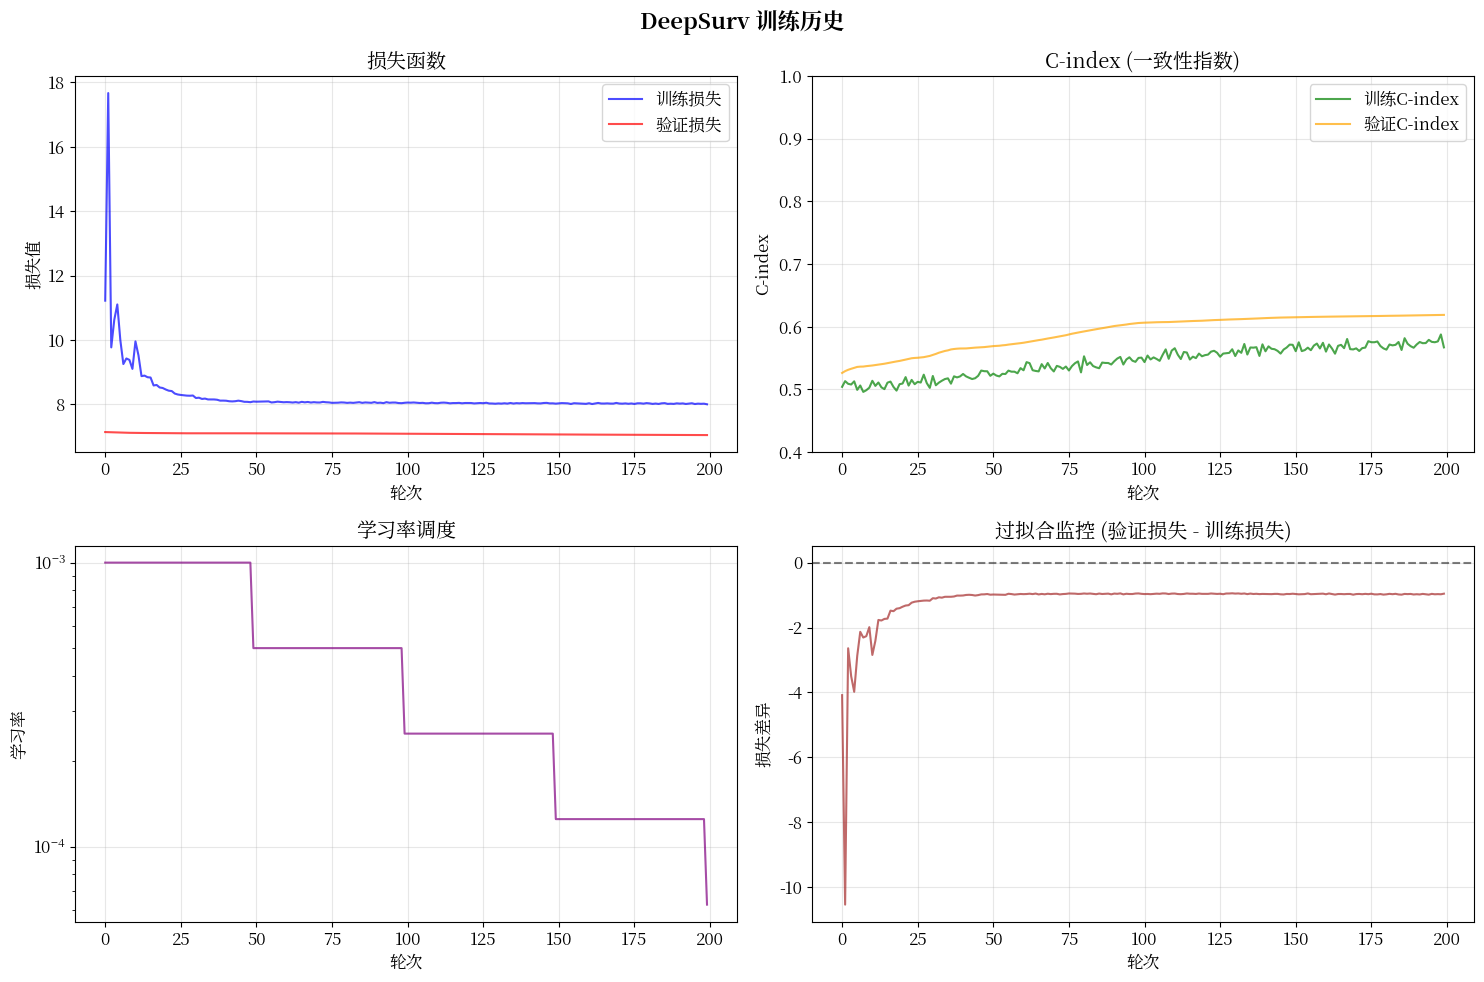


📈 训练摘要:
   初始训练损失: 11.2216
   最终训练损失: 8.0022
   初始验证损失: 7.1390
   最终验证损失: 7.0454
   训练损失改善: 3.2194
   验证损失改善: 0.0936

🎯 性能指标:
   最佳训练C-index: 0.588
   最佳验证C-index: 0.619
   最终训练C-index: 0.567
   最终验证C-index: 0.619

⚠️  可能存在欠拟合 (损失差异: -0.9568)
   建议: 增加模型复杂度、减少正则化或延长训练时间


In [9]:
# 训练历史可视化
print("📊 绘制训练历史...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('DeepSurv 训练历史', fontsize=16, fontweight='bold')

# 损失曲线
axes[0, 0].plot(training_history['train_loss'], label='训练损失', color='blue', alpha=0.7)
axes[0, 0].plot(training_history['val_loss'], label='验证损失', color='red', alpha=0.7)
axes[0, 0].set_title('损失函数')
axes[0, 0].set_xlabel('轮次')
axes[0, 0].set_ylabel('损失值')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# C-index曲线
axes[0, 1].plot(training_history['train_c_index'], label='训练C-index', color='green', alpha=0.7)
axes[0, 1].plot(training_history['val_c_index'], label='验证C-index', color='orange', alpha=0.7)
axes[0, 1].set_title('C-index (一致性指数)')
axes[0, 1].set_xlabel('轮次')
axes[0, 1].set_ylabel('C-index')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(0.4, 1.0)

# 学习率曲线
axes[1, 0].plot(training_history['learning_rate'], color='purple', alpha=0.7)
axes[1, 0].set_title('学习率调度')
axes[1, 0].set_xlabel('轮次')
axes[1, 0].set_ylabel('学习率')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# 损失差异
loss_diff = np.array(training_history['val_loss']) - np.array(training_history['train_loss'])
axes[1, 1].plot(loss_diff, color='brown', alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_title('过拟合监控 (验证损失 - 训练损失)')
axes[1, 1].set_xlabel('轮次')
axes[1, 1].set_ylabel('损失差异')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印训练摘要
print(f"\n📈 训练摘要:")
print(f"   初始训练损失: {training_history['train_loss'][0]:.4f}")
print(f"   最终训练损失: {training_history['train_loss'][-1]:.4f}")
print(f"   初始验证损失: {training_history['val_loss'][0]:.4f}")
print(f"   最终验证损失: {training_history['val_loss'][-1]:.4f}")
print(f"   训练损失改善: {(training_history['train_loss'][0] - training_history['train_loss'][-1]):.4f}")
print(f"   验证损失改善: {(training_history['val_loss'][0] - training_history['val_loss'][-1]):.4f}")

print(f"\n🎯 性能指标:")
print(f"   最佳训练C-index: {max(training_history['train_c_index']):.3f}")
print(f"   最佳验证C-index: {max(training_history['val_c_index']):.3f}")
print(f"   最终训练C-index: {training_history['train_c_index'][-1]:.3f}")
print(f"   最终验证C-index: {training_history['val_c_index'][-1]:.3f}")

# 检查过拟合
final_loss_diff = training_history['val_loss'][-1] - training_history['train_loss'][-1]
if final_loss_diff > 0.1:
    print(f"\n⚠️  可能存在过拟合 (损失差异: {final_loss_diff:.4f})")
    print("   建议: 增加正则化、减少模型复杂度或增加训练数据")
elif final_loss_diff < -0.05:
    print(f"\n⚠️  可能存在欠拟合 (损失差异: {final_loss_diff:.4f})")
    print("   建议: 增加模型复杂度、减少正则化或延长训练时间")
else:
    print(f"\n✅ 模型训练良好 (损失差异: {final_loss_diff:.4f})")

In [2]:
# 模型评估
print("🔍 进行模型评估...")

# 确保模型在评估模式
model.eval()

# 在测试集上进行预测
with torch.no_grad():
    # 获取风险分数
    test_risk_scores = model(X_test_tensor).squeeze().cpu().numpy()
    train_risk_scores = model(X_train_tensor).squeeze().cpu().numpy()

print(f"✅ 预测完成!")
print(f"   测试集风险分数范围: [{test_risk_scores.min():.3f}, {test_risk_scores.max():.3f}]")
print(f"   训练集风险分数范围: [{train_risk_scores.min():.3f}, {train_risk_scores.max():.3f}]")

# 计算C-index
train_c_index = concordance_index(
    y_train_duration,  # 已经是numpy数组，不需要.cpu().numpy()
    -train_risk_scores,  # 负号因为风险越高，生存时间越短
    y_train_event  # 已经是numpy数组，不需要.cpu().numpy()
)

test_c_index = concordance_index(
    y_test_duration,  # 已经是numpy数组，不需要.cpu().numpy()
    -test_risk_scores,
    y_test_event  # 已经是numpy数组，不需要.cpu().numpy()
)

print(f"\n📊 C-index 评估:")
print(f"   训练集 C-index: {train_c_index:.3f}")
print(f"   测试集 C-index: {test_c_index:.3f}")

# 评估模型性能水平
if test_c_index > 0.7:
    performance_level = "优秀"
    performance_emoji = "🎉"
elif test_c_index > 0.6:
    performance_level = "良好"
    performance_emoji = "👍"
elif test_c_index > 0.55:
    performance_level = "一般"
    performance_emoji = "🔄"
else:
    performance_level = "需要改进"
    performance_emoji = "⚠️"

print(f"   模型性能: {performance_emoji} {performance_level}")

# 风险分层分析
def create_risk_groups(risk_scores, n_groups=3):
    """将患者分为不同风险组"""
    if n_groups == 3:
        low_threshold = np.percentile(risk_scores, 33.3)
        high_threshold = np.percentile(risk_scores, 66.7)
        
        risk_groups = np.where(risk_scores <= low_threshold, 'Low Risk',
                              np.where(risk_scores <= high_threshold, 'Medium Risk', 'High Risk'))
    else:
        # 二分组
        median_risk = np.median(risk_scores)
        risk_groups = np.where(risk_scores <= median_risk, 'Low Risk', 'High Risk')
    
    return risk_groups

# 创建风险分组
test_risk_groups = create_risk_groups(test_risk_scores, n_groups=3)
train_risk_groups = create_risk_groups(train_risk_scores, n_groups=3)

print(f"\n🎯 风险分层分析 (测试集):")
for group in ['Low Risk', 'Medium Risk', 'High Risk']:
    mask = test_risk_groups == group
    count = np.sum(mask)
    if count > 0:
        avg_survival = y_test_duration[mask].mean()  # 直接使用numpy数组
        event_rate = y_test_event[mask].mean()      # 直接使用numpy数组
        print(f"   {group}: {count} 患者, 平均生存时间: {avg_survival:.1f}月, 事件率: {event_rate:.1%}")

# Kaplan-Meier生存曲线绘制
print(f"\n📈 绘制Kaplan-Meier生存曲线...")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 测试集风险分组的KM曲线
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()
colors = ['green', 'orange', 'red']
risk_groups_unique = ['Low Risk', 'Medium Risk', 'High Risk']

for i, group in enumerate(risk_groups_unique):
    mask = test_risk_groups == group
    if np.sum(mask) > 0:
        kmf.fit(
            durations=y_test_duration[mask],  # 直接使用numpy数组
            event_observed=y_test_event[mask],  # 直接使用numpy数组
            label=f'{group} (n={np.sum(mask)})'
        )
        kmf.plot_survival_function(ax=axes[0], color=colors[i], linewidth=2)

axes[0].set_title('测试集 Kaplan-Meier 生存曲线')
axes[0].set_xlabel('生存时间 (月)')
axes[0].set_ylabel('生存概率')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# 风险分数分布
axes[1].hist(test_risk_scores[test_risk_groups == 'Low Risk'], 
             alpha=0.7, color='green', label='Low Risk', bins=20)
axes[1].hist(test_risk_scores[test_risk_groups == 'Medium Risk'], 
             alpha=0.7, color='orange', label='Medium Risk', bins=20)
axes[1].hist(test_risk_scores[test_risk_groups == 'High Risk'], 
             alpha=0.7, color='red', label='High Risk', bins=20)

axes[1].set_title('风险分数分布')
axes[1].set_xlabel('风险分数')
axes[1].set_ylabel('患者数量')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Log-rank 检验
print(f"\n📊 Log-rank 检验结果:")
try:
    # 低风险 vs 高风险
    low_mask = test_risk_groups == 'Low Risk'
    high_mask = test_risk_groups == 'High Risk'
    
    if np.sum(low_mask) > 0 and np.sum(high_mask) > 0:
        lr_results = logrank_test(
            y_test_duration[low_mask],  # 直接使用numpy数组
            y_test_duration[high_mask], # 直接使用numpy数组
            y_test_event[low_mask],     # 直接使用numpy数组
            y_test_event[high_mask]     # 直接使用numpy数组
        )
        
        print(f"   低风险 vs 高风险组:")
        print(f"   - 检验统计量: {lr_results.test_statistic:.3f}")
        print(f"   - p值: {lr_results.p_value:.6f}")
        
        if lr_results.p_value < 0.001:
            significance = "极显著 (p < 0.001)"
        elif lr_results.p_value < 0.01:
            significance = "高度显著 (p < 0.01)"
        elif lr_results.p_value < 0.05:
            significance = "显著 (p < 0.05)"
        else:
            significance = "不显著 (p ≥ 0.05)"
        
        print(f"   - 显著性: {significance}")
        
except Exception as e:
    print(f"   Log-rank检验失败: {e}")

# 模型预测示例
print(f"\n🔮 模型预测示例 (测试集前5个患者):")
print("-" * 60)
for i in range(min(5, len(test_risk_scores))):
    risk_score = test_risk_scores[i]
    actual_time = y_test_duration[i]  # 直接使用numpy数组
    actual_event = y_test_event[i]    # 直接使用numpy数组
    risk_group = test_risk_groups[i]
    
    event_status = "死亡" if actual_event == 1 else "删失"
    
    print(f"患者 {i+1}:")
    print(f"   风险分数: {risk_score:.3f}")
    print(f"   风险分组: {risk_group}")
    print(f"   实际生存时间: {actual_time:.1f} 月")
    print(f"   事件状态: {event_status}")
    print("-" * 30)

print(f"\n✅ DeepSurv模型评估完成！")
print(f"   该模型已按照标准DeepSurv架构实现")
print(f"   使用Cox比例风险模型进行生存分析")
print(f"   测试集C-index: {test_c_index:.3f} ({performance_level})")

# 保存预测结果到CSV文件
print(f"\n💾 保存预测结果...")

# 创建processed数据目录
processed_dir = Path('../data/processed')
processed_dir.mkdir(parents=True, exist_ok=True)

# 准备预测结果数据
predictions_data = pd.DataFrame({
    'Duration': y_test_duration,
    'Event': y_test_event,
    'Risk_Score': test_risk_scores,
    'Risk_Group': test_risk_groups
})

# 保存到CSV文件
predictions_csv_path = processed_dir / 'deepsurv_predictions.csv'
predictions_data.to_csv(predictions_csv_path, index=False)

print(f"   ✓ 预测结果已保存到: {predictions_csv_path}")
print(f"   ✓ 包含 {len(predictions_data)} 个测试样本的预测结果")

# 显示保存的数据摘要
print(f"\n保存的预测结果摘要:")
print(f"- 样本数量: {len(predictions_data)}")
print(f"- 事件发生率: {predictions_data['Event'].mean():.2%}")
print(f"- 平均风险分数: {predictions_data['Risk_Score'].mean():.3f}")
print(f"- 风险分数范围: [{predictions_data['Risk_Score'].min():.3f}, {predictions_data['Risk_Score'].max():.3f}]")

# 保存模型
model_save_path = '../model/deepsurv_model.pth'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': model_config,
    'training_config': training_config,
    'training_history': training_history,
    'test_c_index': test_c_index,
    'feature_columns': feature_columns
}, model_save_path)

print(f"💾 模型已保存到: {model_save_path}")

🔍 进行模型评估...


NameError: name 'model' is not defined

In [7]:
# 加载已保存的模型并生成预测结果CSV文件
print("🔧 加载已保存的DeepSurv模型并生成预测结果...")

try:
    # 检查模型文件是否存在
    model_save_path = '../model/deepsurv_model.pth'
    if not os.path.exists(model_save_path):
        print(f"❌ 模型文件不存在: {model_save_path}")
        print("请先运行模型训练部分")
    else:
        # 加载保存的模型数据（设置weights_only=False以兼容旧版本保存的模型）
        print("📂 正在加载模型...")
        checkpoint = torch.load(model_save_path, map_location=device, weights_only=False)
        
        # 重新创建模型
        model_config = checkpoint['model_config']
        model = DeepSurv(**model_config)
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        model.eval()
        
        print(f"✅ 模型加载成功!")
        print(f"   模型C-index: {checkpoint['test_c_index']:.3f}")
        
        # 确保数据在正确的设备上
        X_test_tensor = X_test_tensor.to(device)
        
        # 重新进行预测
        print("🔮 正在生成预测结果...")
        with torch.no_grad():
            test_risk_scores = model(X_test_tensor).squeeze().cpu().numpy()
        
        # 创建风险分组
        def create_risk_groups(risk_scores, n_groups=3):
            if n_groups == 3:
                low_threshold = np.percentile(risk_scores, 33.3)
                high_threshold = np.percentile(risk_scores, 66.7)
                risk_groups = np.where(risk_scores <= low_threshold, 'Low Risk',
                                      np.where(risk_scores <= high_threshold, 'Medium Risk', 'High Risk'))
            else:
                median_risk = np.median(risk_scores)
                risk_groups = np.where(risk_scores <= median_risk, 'Low Risk', 'High Risk')
            return risk_groups
        
        test_risk_groups = create_risk_groups(test_risk_scores, n_groups=3)
        
        # 创建processed数据目录
        processed_dir = Path('../data/processed')
        processed_dir.mkdir(parents=True, exist_ok=True)
        
        # 准备预测结果数据
        predictions_data = pd.DataFrame({
            'Duration': y_test_duration,
            'Event': y_test_event,
            'Risk_Score': test_risk_scores,
            'Risk_Group': test_risk_groups
        })
        
        # 保存到CSV文件
        predictions_csv_path = processed_dir / 'deepsurv_predictions.csv'
        predictions_data.to_csv(predictions_csv_path, index=False)
        
        print(f"✅ 预测结果已保存到: {predictions_csv_path}")
        print(f"   包含 {len(predictions_data)} 个测试样本的预测结果")
        
        # 显示保存的数据摘要
        print(f"\n📊 保存的预测结果摘要:")
        print(f"- 样本数量: {len(predictions_data)}")
        print(f"- 事件发生率: {predictions_data['Event'].mean():.2%}")
        print(f"- 平均风险分数: {predictions_data['Risk_Score'].mean():.3f}")
        print(f"- 风险分数范围: [{predictions_data['Risk_Score'].min():.3f}, {predictions_data['Risk_Score'].max():.3f}]")
        
        # 验证文件确实被创建
        if predictions_csv_path.exists():
            file_size = predictions_csv_path.stat().st_size
            print(f"✅ 文件验证成功! 文件大小: {file_size} 字节")
            
            # 读取并显示前几行
            print(f"\n📋 CSV文件内容预览:")
            saved_data = pd.read_csv(predictions_csv_path)
            print(saved_data.head())
            
        else:
            print("❌ 文件保存失败!")
            
except Exception as e:
    print(f"❌ 处理过程中出错: {e}")
    import traceback
    traceback.print_exc()

🔧 加载已保存的DeepSurv模型并生成预测结果...
📂 正在加载模型...
原版DeepSurv模型创建完成:
  - 输入维度: 46
  - 隐藏层: [100, 50, 25]
  - 激活函数: ReLU
  - Dropout率: 0.5
  - 网络结构: 全连接层 + ReLU + Dropout
✅ 模型加载成功!
   模型C-index: 0.607
🔮 正在生成预测结果...
✅ 预测结果已保存到: ../data/processed/deepsurv_predictions.csv
   包含 4000 个测试样本的预测结果

📊 保存的预测结果摘要:
- 样本数量: 4000
- 事件发生率: 36.20%
- 平均风险分数: -0.164
- 风险分数范围: [-1.008, 0.134]
✅ 文件验证成功! 文件大小: 109128 字节

📋 CSV文件内容预览:
   Duration  Event  Risk_Score   Risk_Group
0        42      1   -0.078121  Medium Risk
1        15      1   -0.092754  Medium Risk
2        39      1   -0.042817    High Risk
3        42      1   -0.185916     Low Risk
4         7      1   -0.151157     Low Risk
✅ 预测结果已保存到: ../data/processed/deepsurv_predictions.csv
   包含 4000 个测试样本的预测结果

📊 保存的预测结果摘要:
- 样本数量: 4000
- 事件发生率: 36.20%
- 平均风险分数: -0.164
- 风险分数范围: [-1.008, 0.134]
✅ 文件验证成功! 文件大小: 109128 字节

📋 CSV文件内容预览:
   Duration  Event  Risk_Score   Risk_Group
0        42      1   -0.078121  Medium Risk
1        15      1   -0.092754  Medium